In [29]:
"""
In this example we demonstrate how to implement a DQN agent and
train it to trade optimally on a periodic price signal.
Training time is short and results are unstable.
Do not hesitate to run several times and/or tweak parameters to get better results.
Inspired from https://github.com/keon/deep-q-learning
"""
import random

import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from tgym.envs import SpreadTrading
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
class DQNAgent:
    def __init__(self,
                 state_size,
                 action_size,
                 episodes,
                 episode_length,
                 memory_size=2000,
                 train_interval=100,
                 gamma=0.95,
                 learning_rate=0.001,
                 batch_size=64,
                 epsilon_min=0.01
                 ):
        self.state_size = state_size
        self.action_size = action_size
        self.memory_size = memory_size
        self.memory = [None] * memory_size
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = epsilon_min
        self.epsilon_decrement = (self.epsilon - epsilon_min)\
            * train_interval / (episodes * episode_length)  # linear decrease rate
        self.learning_rate = learning_rate
        self.train_interval = train_interval
        self.batch_size = batch_size
        self.brain = self._build_brain()
        self.i = 0

    def _build_brain(self):
        """Build the agent's brain
        """
        brain = Sequential()
        neurons_per_layer = 24
        activation = "relu"
        brain.add(Dense(neurons_per_layer,
                        input_dim=self.state_size,
                        activation=activation))
        brain.add(Dense(neurons_per_layer, activation=activation))
        brain.add(Dense(self.action_size, activation='linear'))
        brain.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return brain

    def act(self, state):
        """Acting Policy of the DQNAgent
        """
        action = np.zeros(self.action_size)
        if np.random.rand() <= self.epsilon:
            action[random.randrange(self.action_size)] = 1
        else:
            state = state.reshape(1, self.state_size)
            act_values = self.brain.predict(state)
            action[np.argmax(act_values[0])] = 1
        return action

    def observe(self, state, action, reward, next_state, done, warming_up=False):
        """Memory Management and training of the agent
        """
        self.i = (self.i + 1) % self.memory_size
        self.memory[self.i] = (state, action, reward, next_state, done)
        if (not warming_up) and (self.i % self.train_interval) == 0:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrement
            state, action, reward, next_state, done = self._get_batches()
            reward += (self.gamma
                       * np.logical_not(done)
                       * np.amax(self.brain.predict(next_state),
                                 axis=1))
            q_target = self.brain.predict(state)
            #print "state: ", state[0]
            #print "action[0]: ", action[0]
            #print "action[1]: ", action[1]
            #print "q_target: ", q_target[action[0], action[1]]
            #print "reward: ", reward
            
            q_target[action[0], action[1]] = reward
            return self.brain.fit(state, q_target,
                                  batch_size=self.batch_size,
                                  epochs=1,
                                  verbose=False)

    def _get_batches(self):
        """Selecting a batch of memory
           Split it into categorical subbatches
           Process action_batch into a position vector
        """
        batch = np.array(random.sample(self.memory, self.batch_size))
        state_batch = np.concatenate(batch[:, 0])\
            .reshape(self.batch_size, self.state_size)
        action_batch = np.concatenate(batch[:, 1])\
            .reshape(self.batch_size, self.action_size)
        reward_batch = batch[:, 2]
        next_state_batch = np.concatenate(batch[:, 3])\
            .reshape(self.batch_size, self.state_size)
        done_batch = batch[:, 4]
        # action processing
        action_batch = np.where(action_batch == 1)
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

In [41]:
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/matthewdixon/Downloads/Trading-Gym/')
from tgym.envs import SpreadTrading
#from tgym.gens.deterministic import WavySignal
#from tgym.gens.random import AR1
from tgym.gens.csvstream import CSVStreamer
# Instantiating the environmnent
generator = CSVStreamer(filename='../data/AMZN-L1.csv')
#generator = AR1(a=0.1, ba_spread=0.1)   #WavySignal(period_1=25, period_2=50, epsilon=-0.5)
episodes = 200
episode_length = 400
trading_fee = .0
time_fee = 0
history_length = 2
environment = SpreadTrading(spread_coefficients=[1],
                            data_generator=generator,
                                trading_fee=trading_fee,
                                time_fee=time_fee,
                                history_length=history_length)

In [37]:
generator = CSVStreamer(filename='../data/AMZN-L1.csv')   #WavySignal(period_1=25, period_2=50, epsilon=-0.5)
generator.__dict__

{'_trainable': False,
 'gen_kwargs': {'filename': '../data/AMZN-L1.csv'},
 'generator': <generator object _generator at 0x117d58500>,
 'n_products': 1}

In [38]:
environment.__dict__

{'_action': array([1, 0, 0]),
 '_closed_plot': False,
 '_data_generator': <tgym.gens.csvstream.CSVStreamer at 0x117b5be50>,
 '_depths_history': [array([100., 100.]), array([ 21., 100.])],
 '_entry_price': 0,
 '_episode_length': 1000,
 '_exit_price': 0,
 '_first_render': True,
 '_history_length': 2,
 '_iteration': 0,
 '_position': array([1, 0, 0]),
 '_prices_history': [array([2231.8, 2239.5]), array([2238.1, 2239.5])],
 '_spread_coefficients': [1],
 '_time_fee': 0,
 '_total_pnl': 0,
 '_total_reward': 0,
 '_trading_fee': 0.0,
 'n_actions': 3,
 'state_shape': (12,)}

In [39]:
state = environment.reset()
state

array([2.2375e+03, 2.2395e+03, 2.2375e+03, 2.2395e+03, 1.0000e+02,
       1.0000e+02, 7.4000e+01, 1.0000e+02, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00])

In [43]:
state = environment.reset()
# Instantiating the agent
memory_size = 3000
state_size = len(state)
gamma = 0.96
epsilon_min = 0.01
batch_size = 64
action_size = len(SpreadTrading._actions)
train_interval = 10
learning_rate = 0.001
agent = DQNAgent(state_size=state_size,
                     action_size=action_size,
                     memory_size=memory_size,
                     episodes=episodes,
                     episode_length=episode_length,
                     train_interval=train_interval,
                     gamma=gamma,
                     learning_rate=learning_rate,
                     batch_size=batch_size,
                     epsilon_min=epsilon_min)
# Warming up the agent
for _ in range(memory_size):
        action = agent.act(state)
        next_state, reward, done, _ = environment.step(action)
        agent.observe(state, action, reward, next_state, done, warming_up=True)
        
rews = []
losses = []
epsilons = []
# Training the agent
for ep in range(episodes):
    state = environment.reset()
    rew = 0
    for _ in range(episode_length):
        action = agent.act(state)
        next_state, reward, done, _ = environment.step(action)
        loss = agent.observe(state, action, reward, next_state, done)
        state = next_state
        rew += reward
    print("Ep:" + str(ep)
           + "| rew:" + str(round(rew, 2))
           + "| eps:" + str(round(agent.epsilon, 2))
           + "| loss:" + str(round(loss.history["loss"][0], 4)))
    rews.append(rew)
    epsilons.append(agent.epsilon)
    losses.append(loss.history["loss"][0])

Ep:0| rew:-31085.8| eps:1.0| loss:288335.2188
Ep:1| rew:-82196.0| eps:0.99| loss:150950.75
Ep:2| rew:-46611.0| eps:0.99| loss:95586.0938
Ep:3| rew:-68862.9| eps:0.98| loss:122366.2813
Ep:4| rew:-53316.6| eps:0.98| loss:56659.2891
Ep:5| rew:-44489.3| eps:0.97| loss:52894.9883
Ep:6| rew:-31108.4| eps:0.97| loss:15959.7891
Ep:7| rew:-60056.6| eps:0.96| loss:27363.3242
Ep:8| rew:-46717.1| eps:0.96| loss:26171.6758
Ep:9| rew:-57805.4| eps:0.95| loss:38580.2578
Ep:10| rew:-62274.0| eps:0.95| loss:23699.3652
Ep:11| rew:-40013.5| eps:0.94| loss:10119.0625
Ep:12| rew:-35563.0| eps:0.94| loss:29388.5234
Ep:13| rew:-68888.4| eps:0.93| loss:14200.0625
Ep:14| rew:-31103.1| eps:0.93| loss:3307.3579
Ep:15| rew:-73322.3| eps:0.92| loss:6976.4473
Ep:16| rew:-64408.5| eps:0.92| loss:8803.7334
Ep:17| rew:-57626.5| eps:0.91| loss:28921.1016
Ep:18| rew:-50896.3| eps:0.91| loss:20876.8379
Ep:19| rew:-35458.0| eps:0.9| loss:21338.9512
Ep:20| rew:-59837.7| eps:0.9| loss:12567.2354
Ep:21| rew:-53137.2| eps:0.8

Ep:177| rew:-4403.6| eps:0.12| loss:2950.5864
Ep:178| rew:-8816.8| eps:0.11| loss:452.2312
Ep:179| rew:-6619.4| eps:0.11| loss:477.5137
Ep:180| rew:-8757.9| eps:0.1| loss:3338.2942
Ep:181| rew:-2119.2| eps:0.1| loss:1496.583
Ep:182| rew:-2171.2| eps:0.09| loss:400.8398
Ep:183| rew:-4397.8| eps:0.09| loss:294.7146
Ep:184| rew:-6595.3| eps:0.08| loss:306.5276
Ep:185| rew:-6599.6| eps:0.08| loss:3259.7559
Ep:186| rew:57.9| eps:0.07| loss:295.4872
Ep:187| rew:-6605.4| eps:0.07| loss:675.3683
Ep:188| rew:-2182.0| eps:0.06| loss:666.3038
Ep:189| rew:8.7| eps:0.06| loss:93.1631
Ep:190| rew:-4338.6| eps:0.05| loss:74168.7031
Ep:191| rew:136.4| eps:0.05| loss:3264.6836
Ep:192| rew:5.5| eps:0.04| loss:1563.4845
Ep:193| rew:12.1| eps:0.04| loss:1118.6013
Ep:194| rew:-2190.4| eps:0.03| loss:814339.875
Ep:195| rew:4.8| eps:0.03| loss:881.0529
Ep:196| rew:-2197.2| eps:0.02| loss:564.0079
Ep:197| rew:14.1| eps:0.02| loss:689.0376
Ep:198| rew:1.5| eps:0.01| loss:295.5196
Ep:199| rew:3.0| eps:0.01| los

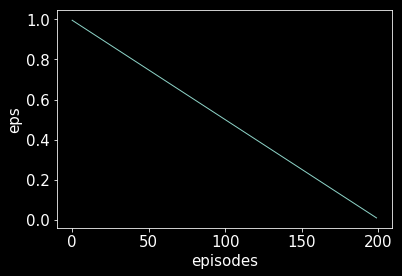

In [52]:
plt.plot(epsilons)
plt.xlabel('episodes')
plt.ylabel('eps')
plt.savefig('epsilons.jpg')

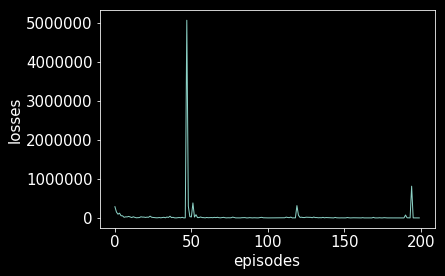

In [51]:
plt.plot(losses)
plt.xlabel('episodes')
plt.ylabel('losses')
plt.savefig('losses.jpg')

In [ ]:
# Running the agent
done = False
state = environment.reset()
while not done:
    action = agent.act(state)
    state, _, done, info = environment.step(action)
    if 'status' in info and info['status'] == 'Closed plot':
        done = True
    else:
        environment.render()